<a href="https://colab.research.google.com/github/sunRise9551/Building_Makemore/blob/main/Makemore_BatchNorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Review

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Dataset

In [7]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-09-17 11:06:31--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.09s   

2023-09-17 11:06:31 (2.42 MB/s) - ‘names.txt’ saved [228145/228145]



In [8]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [9]:
len(words)

32033

In [10]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## MLP Revisited

In [9]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


# Fixing Initial Loss

## Issue

Below code is Optimization step, we want to identify the Initial Loss

In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 28.4938
  10000/ 200000: 2.6654
  20000/ 200000: 2.6381
  30000/ 200000: 2.7673
  40000/ 200000: 2.1780
  50000/ 200000: 2.6614
  60000/ 200000: 2.2672
  70000/ 200000: 1.9174
  80000/ 200000: 2.2796
  90000/ 200000: 2.3978
 100000/ 200000: 1.9056
 110000/ 200000: 2.3627
 120000/ 200000: 1.9990
 130000/ 200000: 2.4281
 140000/ 200000: 2.3419
 150000/ 200000: 2.1175
 160000/ 200000: 1.9509
 170000/ 200000: 1.8603
 180000/ 200000: 2.0507
 190000/ 200000: 2.0213


- Problem: Our initial Loss is way too high.
- Solution: Make probability distribution Uniform.


### Example of Issues

Example 1

In [11]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

Example 2

In [12]:
logits = torch.tensor([0.0, 2.0, 5.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0063, 0.0463, 0.9304, 0.0170]), tensor(0.0722))

Example 3

In [13]:
logits = torch.tensor([0.0, 2.0, 5.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[0].log()
probs, loss

(tensor([0.0063, 0.0463, 0.9304, 0.0170]), tensor(5.0722))

Example 1: Loss = 1.386
- Probability distribution is uniform

Example 2: Loss = 0.072
- Loss is low, because we predicted the correct output
- probs[2], 3rd index in logits is the highest

Example 3: Loss = 5.077
- Loss is high, because we predicted the wrong output
- probs[0], 1st index in logits is not the highest

What we want:
- Uniform distribution of probability
- We can actually make the probability either:
    - All Zeros
    - All Same Values

### Identify Issue in Logits

- Break on first loop
- Identify our logits

In [14]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 2.1791


Checking only the first row of logits

In [16]:
# logits
logits[0]

tensor([-4.6722,  0.3866, -1.0412, -1.5210,  0.7820, -1.1636, -1.6314, -2.2349,
        -1.3722,  0.1318, -1.8610, -1.5670,  2.4515,  1.9424,  0.9991, -0.6578,
        -1.9764, -5.5571,  1.0462,  1.4402, -0.1736, -0.5661,  1.6520, -2.4421,
        -2.1513, -0.3296,  0.2990], grad_fn=<SelectBackward0>)

Our logits is taking extreme values

## Solution

### Re-Initialize Network

1. Our logits is --> logits = h @ W2 + b2
2. We don't want bias, so we make b2 * 0
3. We want our W2 to be small, so the output loss will be low

In [22]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # <---------- modify W2
b2 = torch.randn(vocab_size,                      generator=g) * 0    # <---------- modify b2

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


### Re-Optimize

Break after first loop, and check logits

In [23]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.3277


Logits are now much closer to 0

In [19]:
logits[0]

tensor([-0.0460,  0.3116, -0.1364,  0.0526,  0.1807, -0.0630, -0.0736, -0.0335,
        -0.0208,  0.1213,  0.1839, -0.0565,  0.0649, -0.2445, -0.1240,  0.0556,
         0.0023, -0.1085, -0.2924, -0.0622,  0.2324,  0.1036,  0.1477, -0.1076,
        -0.2047,  0.0865,  0.1166], grad_fn=<SelectBackward0>)

### Re-run full Optimization

In [24]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2144
  10000/ 200000: 1.9288
  20000/ 200000: 1.9662
  30000/ 200000: 2.0635
  40000/ 200000: 2.0994
  50000/ 200000: 2.2196
  60000/ 200000: 2.1243
  70000/ 200000: 2.7595
  80000/ 200000: 2.5463
  90000/ 200000: 2.2940
 100000/ 200000: 2.4423
 110000/ 200000: 1.8244
 120000/ 200000: 2.2097
 130000/ 200000: 1.9917
 140000/ 200000: 1.8389
 150000/ 200000: 2.3497
 160000/ 200000: 2.2176
 170000/ 200000: 1.8031
 180000/ 200000: 1.9221
 190000/ 200000: 2.1234


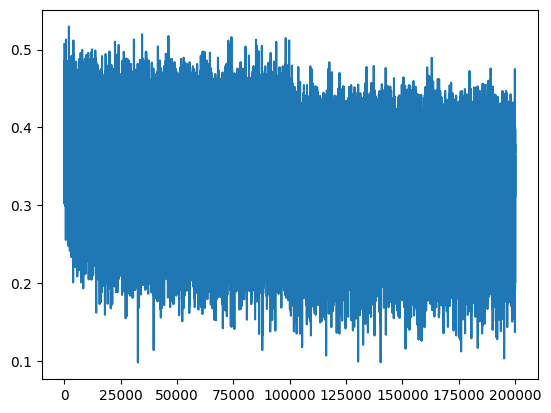

In [25]:
plt.plot(lossi)

# Fixing Saturated Tanh

## Issue

### Tanh

Our Tanh output

- h = torch.tanh(hpreact) # hidden layer

In [26]:
h

tensor([[ 0.9992,  0.9697, -0.9752,  ..., -1.0000,  1.0000,  1.0000],
        [ 1.0000, -0.4036, -0.7855,  ...,  0.8972,  1.0000, -0.8518],
        [-0.9947, -0.9997, -1.0000,  ...,  0.9775, -0.7211, -1.0000],
        ...,
        [-0.9994, -0.9886, -1.0000,  ..., -0.3745, -0.9999, -1.0000],
        [ 1.0000, -1.0000, -1.0000,  ..., -0.9999, -1.0000,  0.0997],
        [-1.0000, -0.5574, -1.0000,  ...,  1.0000, -0.9965, -1.0000]],
       grad_fn=<TanhBackward0>)

Visualize Tanh output in histogram

In [27]:
h.shape

torch.Size([32, 200])

In [29]:
h.view(-1)

tensor([ 0.9992,  0.9697, -0.9752,  ...,  1.0000, -0.9965, -1.0000],
       grad_fn=<ViewBackward0>)

(array([2193.,  111.,   89.,   74.,   63.,   35.,   27.,   47.,   54.,
          25.,   19.,   27.,   26.,   18.,   27.,   16.,   23.,   25.,
          14.,   18.,   25.,   12.,   16.,   20.,   15.,   10.,   31.,
          27.,   28.,   10.,   20.,   21.,   20.,   17.,   13.,    7.,
          18.,   14.,   26.,   22.,   27.,   13.,   28.,   47.,   35.,
          39.,   82.,   93.,  131., 2602.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

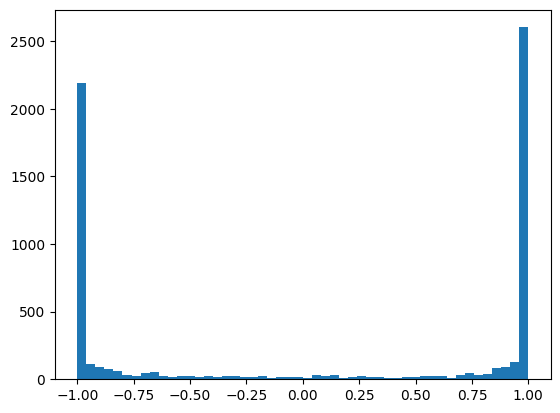

In [31]:
plt.hist(h.view(-1).tolist(), 50)

### hpreact

Visualize hpreact, that feeds in to Tanh

(array([  2.,   2.,   2.,   3.,   2.,   6.,   8.,  16.,  15.,  20.,  28.,
         32.,  28.,  67.,  64.,  88., 141., 194., 190., 226., 249., 271.,
        319., 346., 517., 473., 456., 326., 373., 302., 327., 318., 226.,
        154., 159.,  96.,  82.,  56.,  65.,  45.,  32.,  20.,  18.,  16.,
          6.,   5.,   1.,   5.,   1.,   2.]),
 array([-28.18483162, -27.07398624, -25.96314087, -24.85229549,
        -23.74145012, -22.63060474, -21.51975937, -20.40891399,
        -19.29806862, -18.18722324, -17.07637787, -15.96553249,
        -14.85468712, -13.74384174, -12.63299637, -11.52215099,
        -10.41130562,  -9.30046024,  -8.18961487,  -7.07876949,
         -5.96792412,  -4.85707874,  -3.74623337,  -2.63538799,
         -1.52454262,  -0.41369724,   0.69714813,   1.80799351,
          2.91883888,   4.02968426,   5.14052963,   6.25137501,
          7.36222038,   8.47306576,   9.58391113,  10.69475651,
         11.80560188,  12.91644726,  14.02729263,  15.13813801,
         16.248983

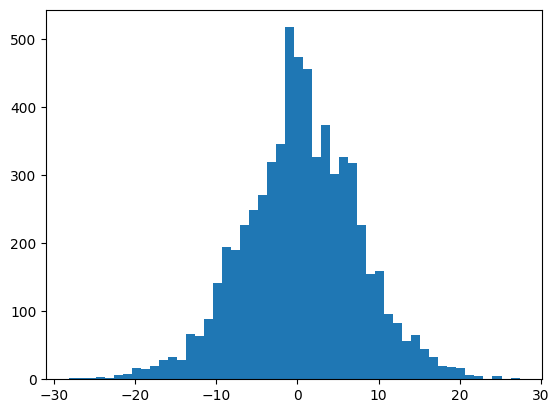

In [32]:
plt.hist(hpreact.view(-1).tolist(), 50)

### Tanh Backpropagate

Recall our Tanh backpropagate function in Micrograd

In [ ]:
# -------------------------------------------------
def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    # backward for tanh
    def _backward():
      self.grad = (1-t**2) * out.grad
    out._backward = _backward
# --------------------------------------------------

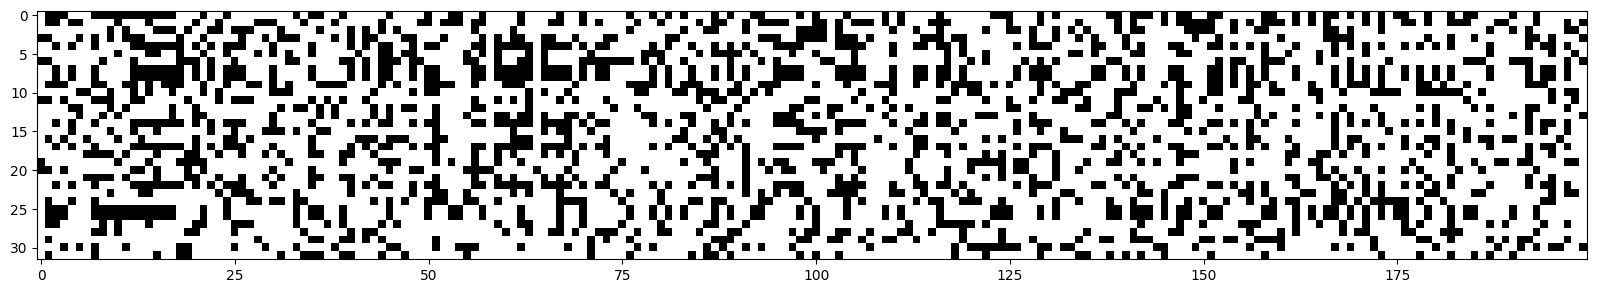

In [33]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Activation functions

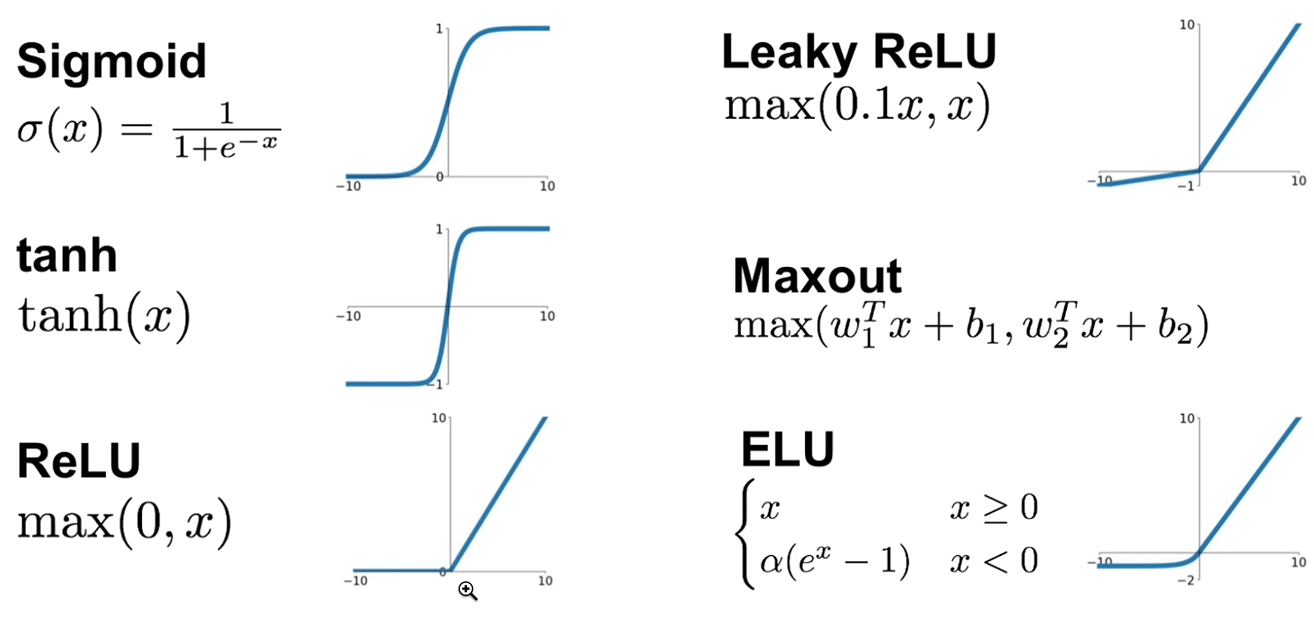

## Solution

### Re-Initialize Network

hpreact is one of the issue, we want the output of hpreact to be closer to 0 as much as possible

  - hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  
  - h = torch.tanh(hpreact) # hidden layer

We can also squash the weights.



In [43]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1  # <---------- modify W1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # <---------- modify b1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


### Re-Optimize

In [35]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.3067


### Re-plot Graph

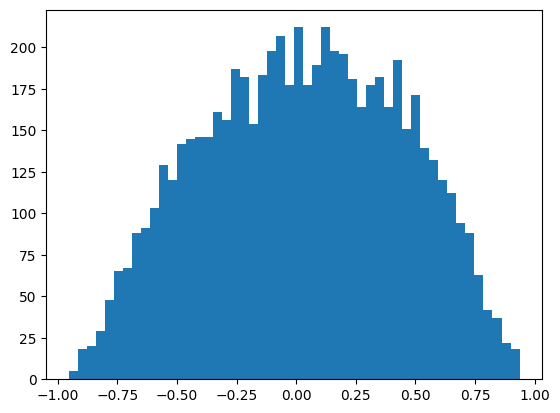

In [39]:
plt.hist(h.view(-1).tolist(), 50);

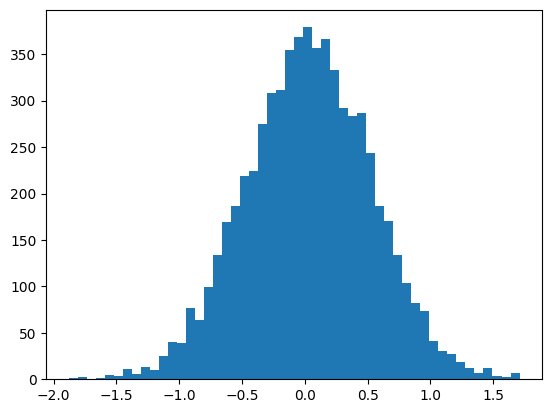

In [40]:
plt.hist(hpreact.view(-1).tolist(), 50);

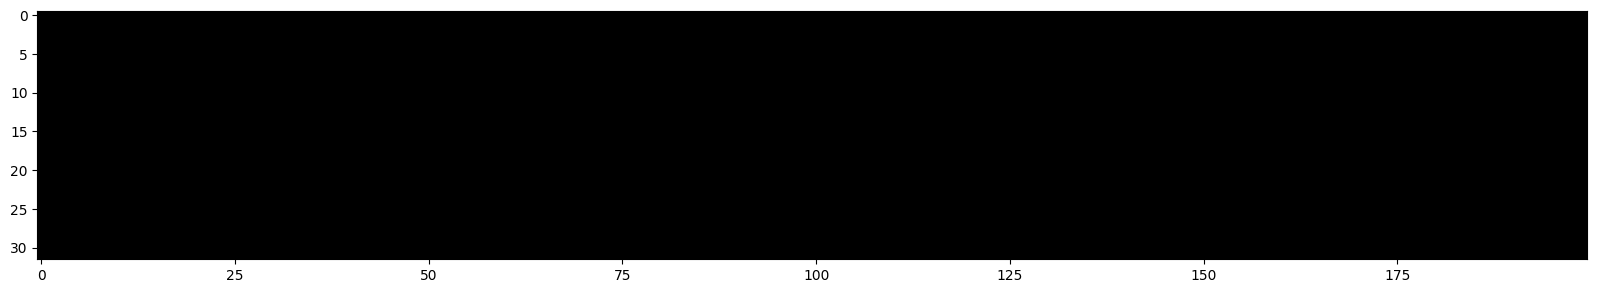

In [36]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Modify W1 to 0.2 to see the differences

In [41]:
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  # <---------- modify W1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # <---------- modify b1

In [44]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000: 3.3134


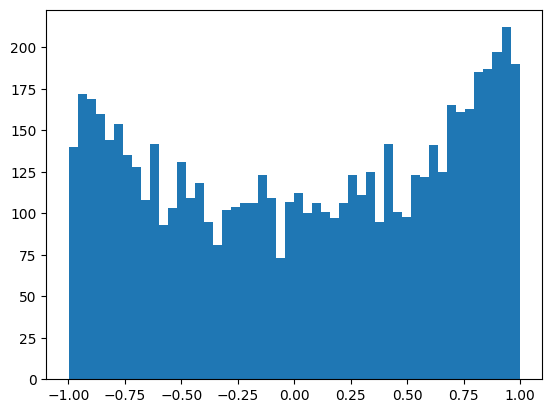

In [45]:
plt.hist(h.view(-1).tolist(), 50);

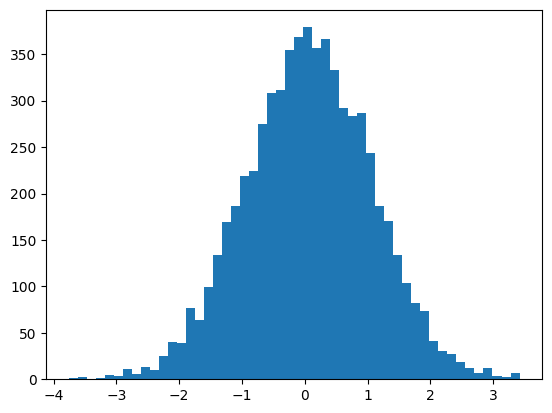

In [46]:
plt.hist(hpreact.view(-1).tolist(), 50);

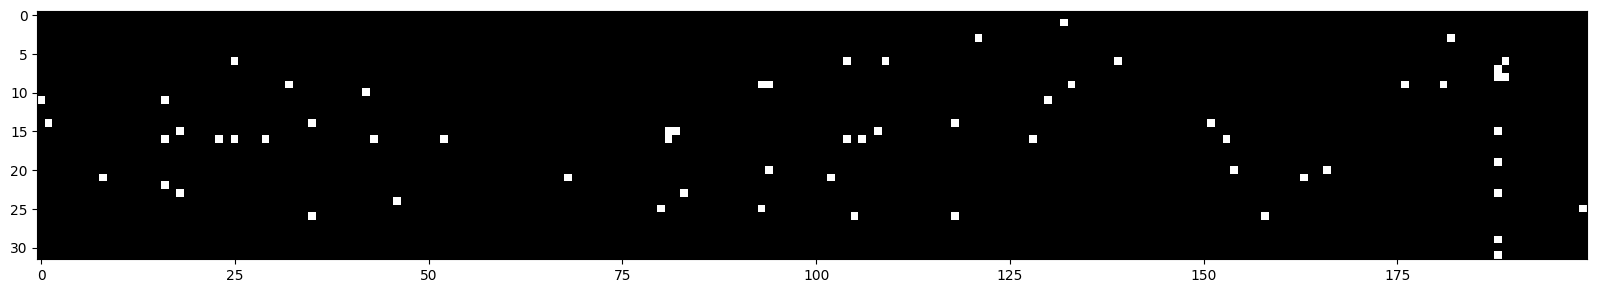

In [47]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

## Kaiming Init

tensor(-0.0098) tensor(1.0067)
tensor(0.0012) tensor(3.1344)


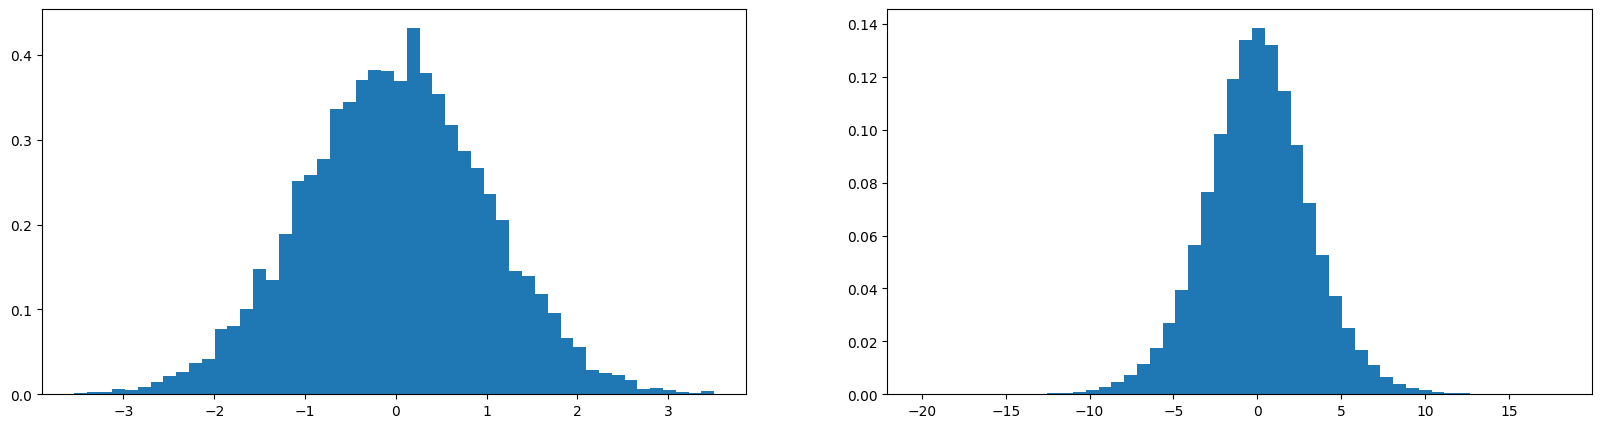

In [49]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(-0.0011) tensor(0.9933)
tensor(-0.0071) tensor(1.6001)


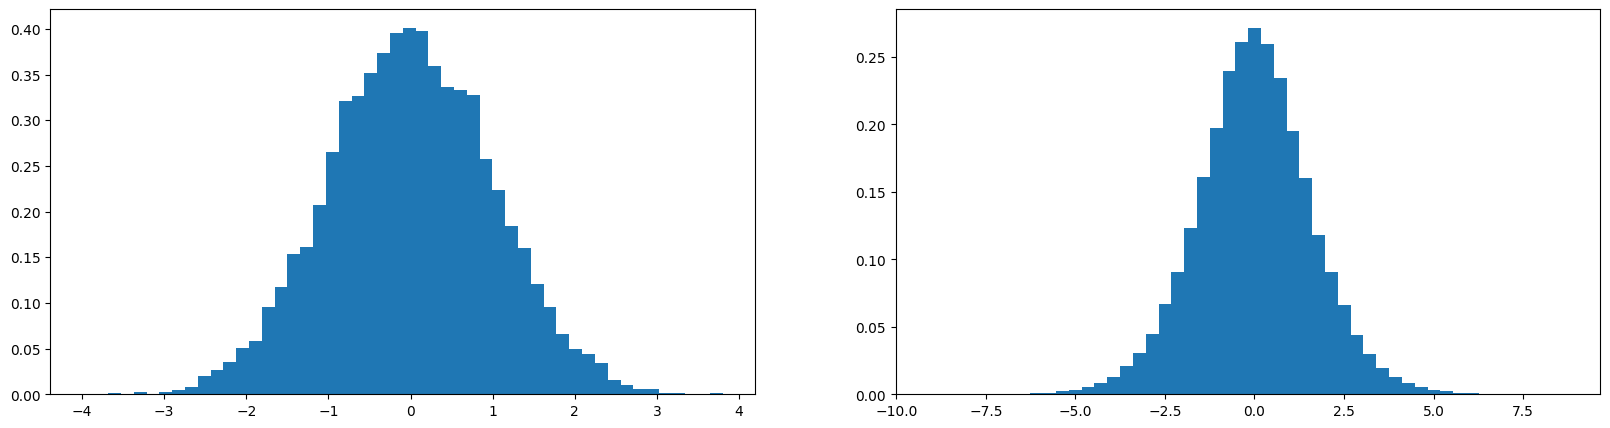

In [50]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(0.0043) tensor(1.0073)
tensor(-0.0002) tensor(0.0635)


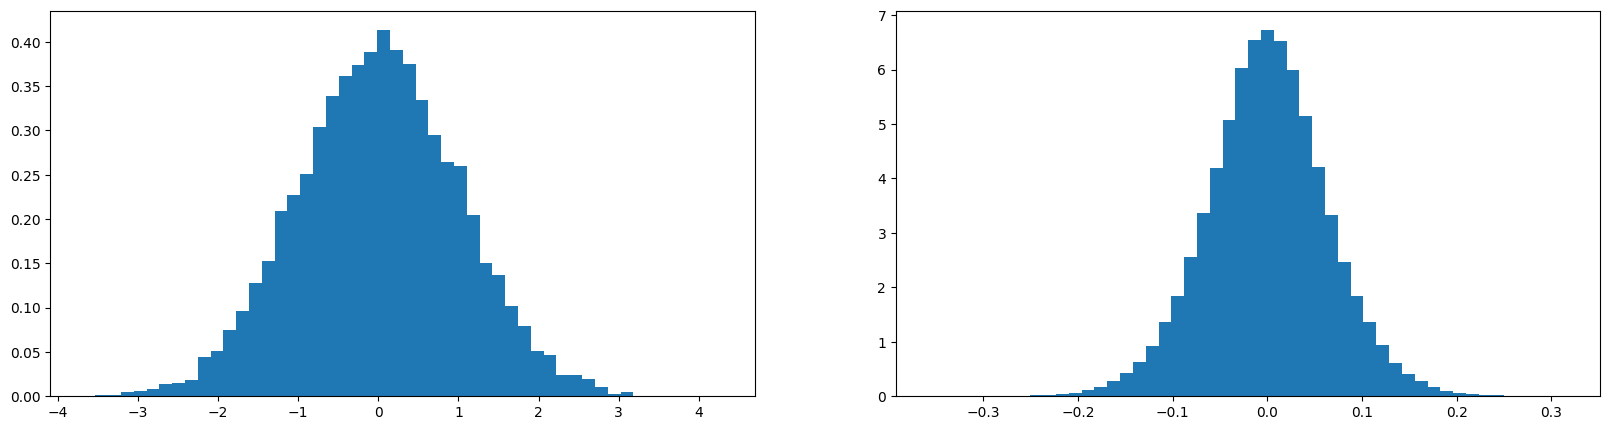

In [51]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

Square root of Fan_in

tensor(-0.0028) tensor(0.9990)
tensor(0.0005) tensor(0.9876)


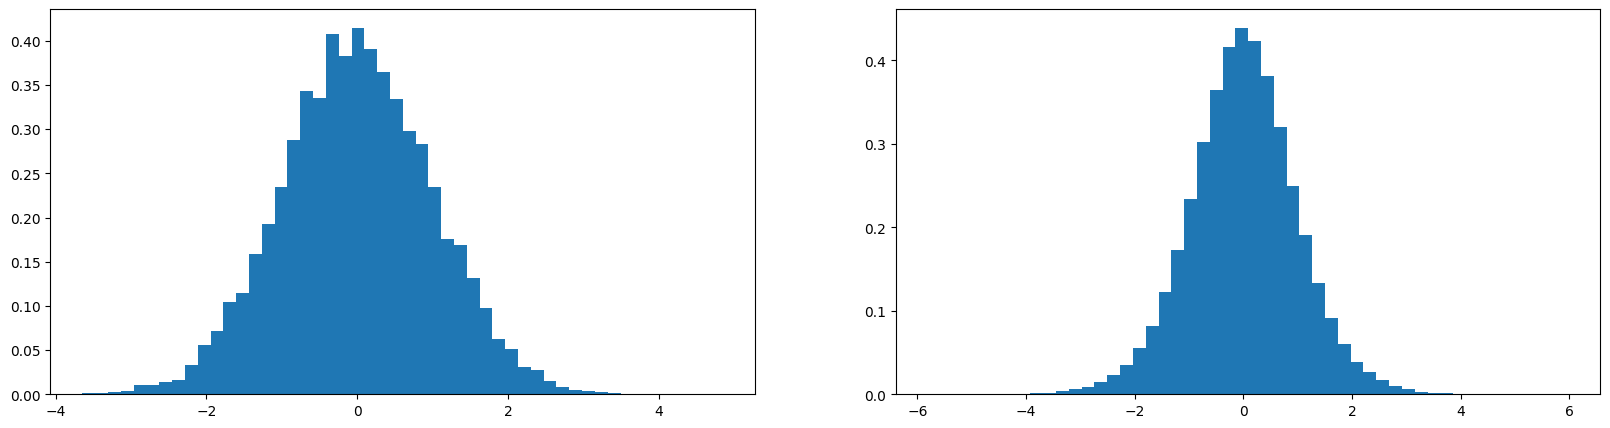

In [52]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [3]:
torch.randn(1000).std()

tensor(0.9965)

In [4]:
(torch.randn(1000) * 0.2).std()

tensor(0.1954)

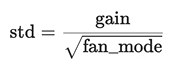

We will be using fan_mode = fan_in, the inputs features.

Let's say we want to calculate the std for Tanh

In [5]:
(5/3) / (30**0.5) # n_embd * block_size of W1 is 30

0.3042903097250923

In [12]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5 # 0.2
                                                                        # Our inputs
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [13]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3179
  10000/ 200000: 2.1931
  20000/ 200000: 2.3239
  30000/ 200000: 2.5364
  40000/ 200000: 1.9723
  50000/ 200000: 2.3183
  60000/ 200000: 2.3864
  70000/ 200000: 2.1508
  80000/ 200000: 2.3094
  90000/ 200000: 2.2279
 100000/ 200000: 1.8242
 110000/ 200000: 2.1281
 120000/ 200000: 1.9468
 130000/ 200000: 2.3681
 140000/ 200000: 2.1050
 150000/ 200000: 2.1441
 160000/ 200000: 1.7716
 170000/ 200000: 1.7771
 180000/ 200000: 1.9463
 190000/ 200000: 1.8029


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

# Batch Normalization

We want our hidden state(hpreact) to be gaussian, so what they think of is just take the output and normalize them to be gaussian.

In [ ]:
# Linear layer
  hpreact = embcat @ W1 # <-- We want to make the output Gaussian
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer

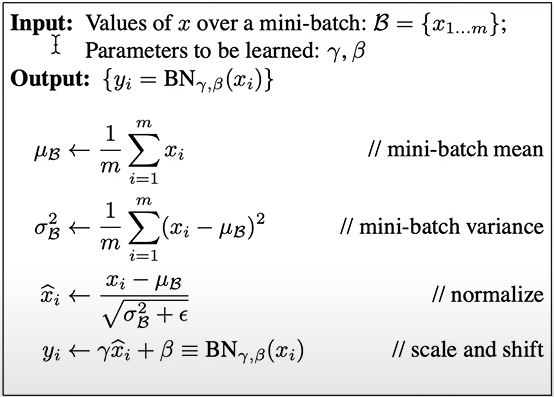

## Mean

In [16]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

## Std

In [17]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

## Normalize

In [19]:
(hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

tensor([[ 2.3856,  0.9659, -0.7816,  ..., -0.6306,  1.8803,  0.9429],
        [ 1.0294, -0.6936, -0.6939,  ..., -0.8711,  0.1920, -0.4285],
        [-1.1033,  1.7943, -0.6943,  ...,  0.2808, -0.6332,  0.1416],
        ...,
        [ 0.4402, -0.9988, -0.5516,  ...,  0.1733, -0.6333, -1.0852],
        [ 0.4704,  1.0053,  1.8437,  ..., -0.6553, -0.0078,  0.5524],
        [-0.2959, -0.0100, -3.2878,  ...,  0.2405, -0.8089,  0.0037]],
       grad_fn=<DivBackward0>)

## Scale and Shift

In [ ]:
# Initialize 'gain' and 'bias'
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

In [ ]:
bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

## Re-Initialize Network

In [20]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/(n_embd * block_size)**0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Initialize 'gain' and 'bias'
# ----------------------------------
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# ----------------------------------

parameters = [C, W1, W2, b2, bngain, bnbias] # <--- Add into Parameters
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

11697


## Re-Optimize

In [21]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  # Linear layer
  hpreact = embcat @ W1

  # Batch Normalization
  # ---------------------------------
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # ---------------------------------

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1942
  20000/ 200000: 2.3443
  30000/ 200000: 2.4160
  40000/ 200000: 1.9913
  50000/ 200000: 2.2978
  60000/ 200000: 2.5254
  70000/ 200000: 2.0707
  80000/ 200000: 2.3107
  90000/ 200000: 2.0663
 100000/ 200000: 1.9933
 110000/ 200000: 2.3179
 120000/ 200000: 1.9123
 130000/ 200000: 2.4505
 140000/ 200000: 2.4321
 150000/ 200000: 2.2003
 160000/ 200000: 2.0463
 170000/ 200000: 1.8839
 180000/ 200000: 1.9983
 190000/ 200000: 1.8873


In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0785984992980957
val 2.112783670425415


## Loss Log

    loss log

    original:
    train 2.1245384216308594
    val   2.168196439743042

    fix softmax confidently wrong:
    train 2.07
    val   2.13

    fix tanh layer too saturated at init:
    train 2.0355966091156006
    val   2.1026785373687744

    use semi-principled "kaiming init" instead of hacky init:
    train 2.0376641750335693
    val   2.106989622116089

    add batch norm layer:
    train 2.0668270587921143
    val 2.104844808578491

# Batch Norm in Inference

## Solution 1

- Our training set now takes in batches.
- Therefore, we need one extra step after training.
- Estimate the mean and std for entire training set.

In [23]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [24]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  # --------------------------------------------------------
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  # --------------------------------------------------------
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0786521434783936
val 2.1130924224853516


## Solution 2

- Setup a running mean and std

### Re-Initialize Network

In [28]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
# Initialize 'bnmean_running' and 'bnstd_running'
# ----------------------------------------------
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
# ----------------------------------------------

parameters = [C, W1, W2, b2, bngain, bnbias] # <-- We do not have to add them to parameters
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


### Re-Structure Optimization

In [29]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  # Linear layer
  hpreact = embcat @ W1

  # Batch Normalization
  # ----------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # ----------------------------------------------------------

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [30]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  # --------------------------------------------------------
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  # --------------------------------------------------------
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


## Further Optimize

We don't want the bias, because bias is useless in Batch Normalization.

In [ ]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01 <------ Not using bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias] # <-- We do not have to add them to parameters
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  # Linear layer
  hpreact = embcat @ W1 #+ b1 <------- Taking out bias
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
